# Step 2: Visualization
In this notebook, we use the data organized in the `clean-data` notebook to make visualziations.

In [1016]:
# Time for timestamps on plotly models
import time

# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Scipy stats for statistical tests
import scipy.stats

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Plotly for maps
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.grid_objs import Grid, Column
from plotly import tools

# statsmodel for seasonal decomposition  
from statsmodels.tsa.seasonal import seasonal_decompose

# minmax scaler to standardize variables for plotting
from sklearn.preprocessing import MinMaxScaler

# cosine similarity for comparing states with similar provisions
from sklearn.metrics.pairwise import cosine_similarity


# Other things I'll be using
from sklearn.preprocessing import LabelEncoder

In [1017]:
# First let's read in our clean data
provisions_file = './data/raw/provisions.csv' 
provisions_cat_file = './data/raw/provision_categories.csv'
lat_long_file = './data/cleaned/lat_long.csv'
by_date_total_file = './data/cleaned/by_date_total.csv'
annual_file = './data/cleaned/annual.csv'

provisions_df = pd.read_csv(provisions_file, parse_dates=True)
provisions_cat_df = pd.read_csv(provisions_cat_file)
lat_long_df = pd.read_csv(lat_long_file, parse_dates=True, index_col=0)
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)
annual_df = pd.read_csv(annual_file, parse_dates=True, index_col=0)

In [1018]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 15, 8
mpl.rc("savefig", dpi=240)

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# make markers smaller
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['axes.edgecolor'] = '#d6dbdf'
mpl.rcParams['xtick.color'] = '#d6dbdf'
mpl.rcParams['ytick.color'] = '#d6dbdf'

# change font
mpl.rcParams['font.family'] = 'Open Sans'

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['#2471A3', '#7FB3D5'])

# define colors for republican and democrat
rep_color='#e74c3c'
dem_color='#3498db'

# Function to apply styling that can't be set default with mpl.rcParams
def apply_styling(grid='both'):
    plt.xticks(color='k')
    plt.yticks(color='k')
    if grid:
        plt.grid(axis=grid)

In [1019]:
# Exclude District of Columbia from some of our visualizations, as it is an extreme outlier
annual_df = annual_df[annual_df['state'] != 'District of Columbia']

# Make a list of states so we can iterate through them later
states = annual_df.groupby('state').count().index

# Get a random subset of n states to plot (too many states) 
def get_random_states(n=12, seed=1):
    # referencing annual_df from outside function
    n = min([n, 50])
    return list(annual_df.groupby('state').count().sample(n, random_state=seed).index)

# Function to plot feature trends easily
def plot_feature_trends(column1, label1=None, column2='gun_deaths_norm', label2=None,
                        title=None, states=None, rows=4, cols=3, seed=1, 
                        colors=['#6377cb', '#cb63ab'], highlight=[], order=(0, 0)):
    """Sample random states and plot featuresagainst eaceh other.
    
    column1     (str): Name of the column from annual_df to plot column2 trends 
    against. Both features specified will be min-maxed to share a y axis.
    
    label1      (str): label that will appear in the legend as the name of the
    first feature. If unspecified, defaults to column1.
    
    column2     (str): Name of the 2nd column to plot trends against. Defaults 
    to 'gun_deaths_norm'.
    
    label2      (str): label that will appear in the legend as the name of the
    second feature. If unspecified, defaults to column2.
    
    states     (list): List of states that will be plotted
    
    title       (str): Title of the plot. If unspecified, title will be generated.
    
    row         (int): Number of rows in the subplot grid.
    
    col         (int): Number of columns in the subplot grid.
    
    seed        (int): Random state used to sample the states with.
    
    colors     (list): Colors to use (length 2).
    
    highlight  (list): List of states to highlight
    
    order   (int,int): A pair of integers corresponding to the order difference to use 
    for each trend removal.  
    """
    
    if label1 is None:
        label1 = column1
        
    if label2 is None:
        if column2 == 'gun_deaths_norm':
            label2 = 'Gun Homicide Rate'
        else:
            label2 = column2
    
    # Get n random states to fill the subplot
    n = rows * cols
    if states is None:
        states = get_random_states(n, seed)
    
    # referencing annual_df from outside the function; get relevant columns
    temp_df = annual_df[['state', 'year', column1, column2]]
    temp_df = temp_df.dropna()
    
    # Make the figure bigger
    plt.figure(figsize=(15, 3 * rows))
    
    # For each state...
    for i, state in enumerate(states):
        ax = plt.subplot(rows, cols, i + 1)
        get_state = temp_df['state'] == state

        # Get the first column, remove trend, and apply min-max
        first = temp_df.loc[get_state, ['year', column1]]
        first = first.set_index('year')
        if order[0] != 0:
            first = first - first.shift(order[0])
        first = first.dropna()
        first_scaler = MinMaxScaler()
        first[column1] = first_scaler.fit_transform(first)

        # Get the second column, remove trend, and apply min-max
        second = temp_df.loc[get_state, ['year', column2]]
        second = second.set_index('year')
        if order[1] != 0:
            second = second - second.shift(order[1])
        second = second.dropna()
        second_scaler = MinMaxScaler()
        second[column2] = second_scaler.fit_transform(second)

        # Plot the two trends on the same set of axes
        plt.plot(first, label=label1, color=colors[0])
        plt.plot(second, label=label2, color=colors[1])
        plt.title(state)
        apply_styling()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Highlight if state is a highlight
        if state in highlight:
            ax.set_facecolor(('#F4FCFB'))
        
        # Only make a legend on the first plot
        if i == 0:
            plt.legend() 
            
    # Create a title if there is none:
    if title is None:
        title = "{} and {} Trends ({}-{})".format(label1,
                                                label2,
                                                first.index.min(),
                                                first.index.max())
    plt.suptitle(title, fontsize=18)
    plt.subplots_adjust(top=0.92, hspace=0.4) # Space out the plots a bit more vertically
    plt.show()

***
# Trend Visualization
Let's view the trend for gun homicides over the United States as a whole.

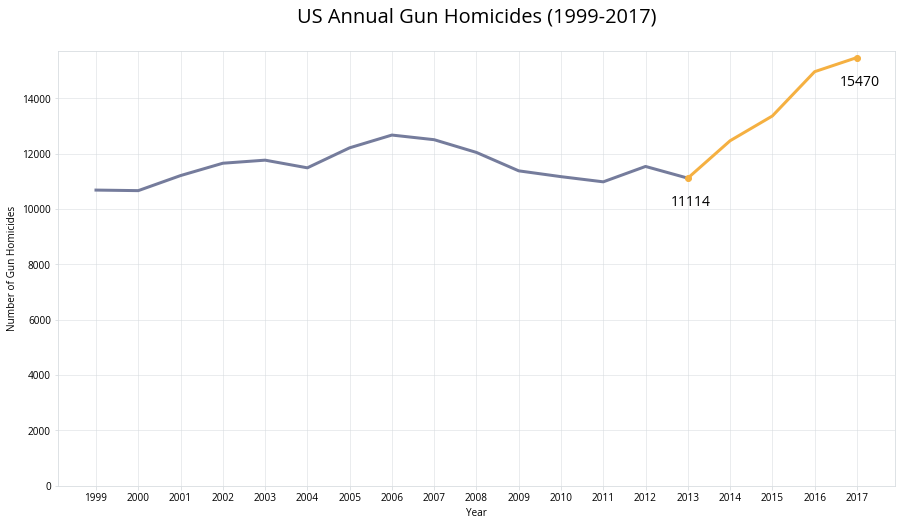

In [1020]:
# For our first visualizations, let's just plot the gun homicide trend in two ways:

# Annual from 1999-2017
country_annual_df = annual_df[['state', 'year', 'gun_deaths']].groupby('year').sum()
country_annual_df_2012 = country_annual_df.loc[:2013]
country_annual_df_2017 = country_annual_df.loc[2013:]

# Plot the line graphs (we split in two for emphasis on 2013:2017)
plt.plot(country_annual_df_2012.index, country_annual_df_2012, linewidth=3,
            color='#757C9C')
plt.plot(country_annual_df_2017.index, country_annual_df_2017, linewidth=3, 
              markevery=[0, 4], marker='o', color='#F5B041', markersize=6)

# Set title, labels, and xticks
plt.title('US Annual Gun Homicides (1999-2017)\n', size=20)
plt.xlabel('Year')
plt.ylabel('Number of Gun Homicides')
plt.ylim(0)
plt.xticks(range(1999, 2018))

# Add extra styling and annotations
deaths_2013 = country_annual_df.loc[2013][0]
deaths_2017 = country_annual_df.loc[2017][0]
plt.annotate("{:.0f}".format(deaths_2013), xy=(2013 - 0.4, deaths_2013 - 1000), size=14)
plt.annotate("{:.0f}".format(deaths_2017), xy=(2017 - 0.4, deaths_2017 - 1000), size=14)
# plt.annotate('{:.0f}'.format(deaths_2017), xy=(2017, deaths_2017),  
#              xycoords='data', xytext=(0.928, 0.655), textcoords='axes fraction',
#              arrowprops=dict(arrowstyle="-", shrinkA=10, shrinkB=10),
#              size=14)

apply_styling()
plt.show()

In [1021]:
# Daily mean with window from 2014-2017
win_size = 60

country_gun_df = by_date_total_df['2014':'2017'].sum(axis=1)
country_gun_df.rolling(window=win_size).mean().plot(figsize=(15,10))

plt.title('US Daily Gun Homicides (2014-2017)\n', size=20)
plt.xlabel('Date')
plt.ylabel('Number of Gun Homicides (average over {} day window)\n'.format(win_size))
plt.xticks(plt.xticks()[0], ['Jan 2014', 'Jul 2014', 'Jan 2015', 'Jul 2015',
                             'Jan 2016', 'Jul 2016', 'Jan 2017', 'Jul 2017'], 
                               rotation=0, ha='center')
plt.ylim(0)
apply_styling()
plt.savefig('abc')

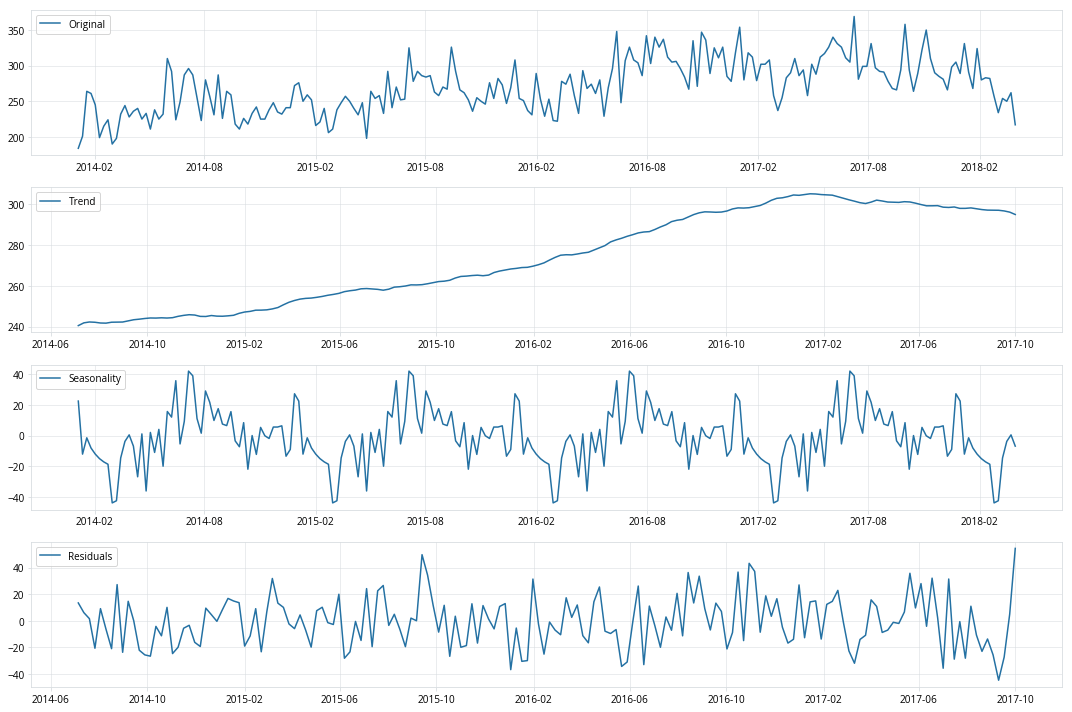

In [1022]:
# It looks like there's some seasonality, and an upward trend, but let's take a closer look:

# Plot and the decomposition of the time series and into trend, seasonal, and residual noise.
time_series = by_date_total_df.resample('W').sum().sum(axis=1)
decomposition = seasonal_decompose(time_series)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(4,1,1)
plt.plot(time_series, label='Original')
plt.legend(loc='upper left')
apply_styling()

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
apply_styling()

plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
apply_styling()

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
apply_styling()

plt.tight_layout()
plt.show()

## From these visualizations, there seems to be a *upward trend*, and some seasonality that suggests *spikes in gun violence during the summer* and *at the beginning of each new year*.

***

# Features as Data Points

Here, we create several scatter plots, treating each *feature, gun violence rate* value as a data point. These points are plotted irrespective of the year or state they occur in. The goal of these visualizations is **to see whether the value of these features has any correlation with gun violence rates**.

\* **Note**: In this notebook, **gun homicide rate** is defined as the number of gun homicides per 100,000 people.

## Other crime rates, income, and total gun control provisions

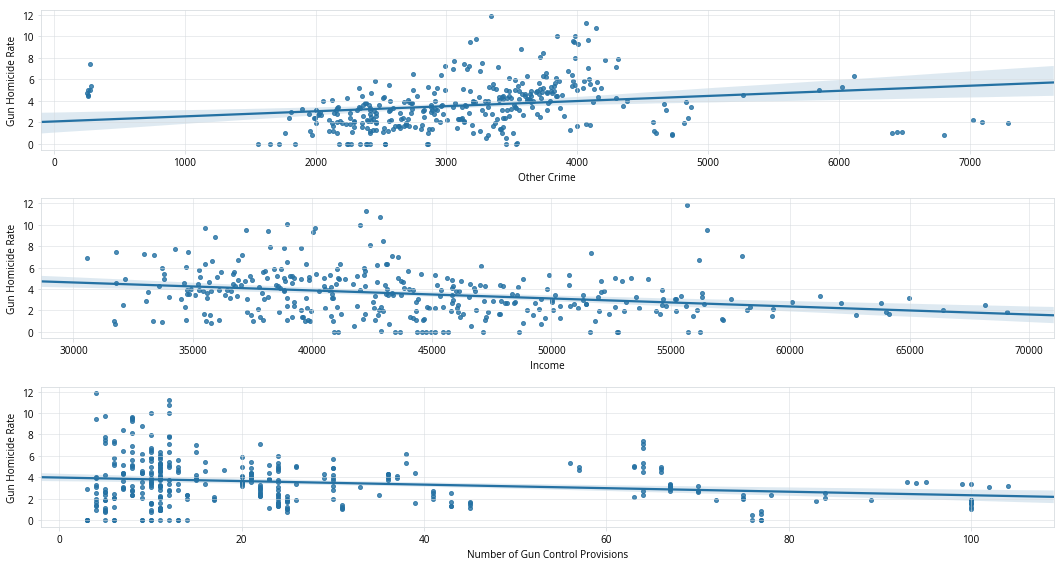

In [1023]:
# Plot these features against gun homicide rates
to_plot = ['other_crime_norm', 'income', 'lawtotal']
xlabels = ['Other Crime', 'Income', 'Number of Gun Control Provisions']
n_items = len(to_plot)

temp_df = annual_df[to_plot + ['gun_deaths_norm']].dropna()

for i, column in enumerate(to_plot):
    plt.subplot(n_items, 1, i + 1)
    sns.regplot(temp_df[column], temp_df['gun_deaths_norm'])
    plt.ylabel('Gun Homicide Rate')
    plt.xlabel(xlabels[i])
    apply_styling()

plt.subplot(n_items, 1, 1)
plt.tight_layout()
plt.show()

From these visualizations it appears that gun violence is **positively correlated with other crime** and **negatively correlated with income** and **number of gun control provisions**.
***

## Alcohol Consumption 

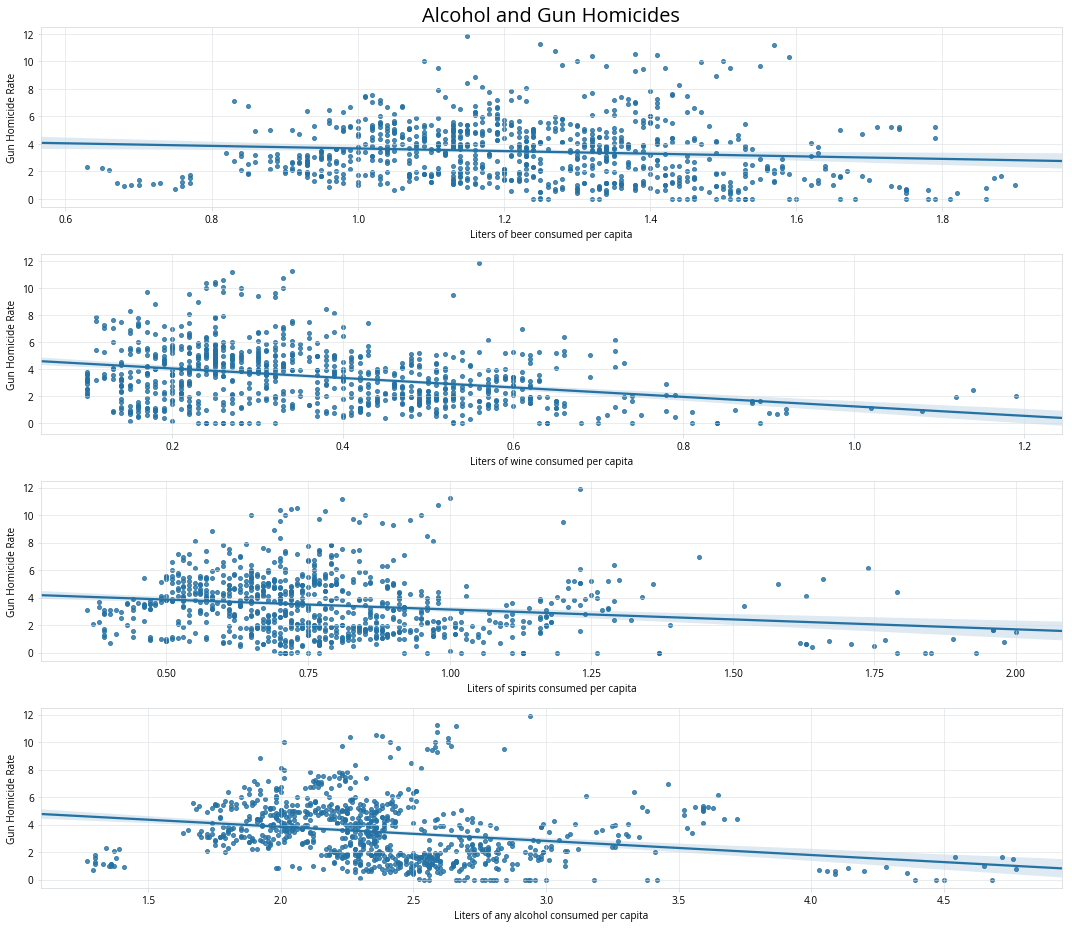

In [1024]:
# Plot gun deaths as they relate to alcohol consumption
to_plot = ['beer', 'wine', 'spirits', 'alcohol_consumed']
xlabels = ['beer', 'wine', 'spirits', 'any alcohol']
n_items = len(to_plot)

temp_df = annual_df[to_plot + ['gun_deaths_norm']].dropna()

plt.figure(figsize=(15,13))
for i, column in enumerate(to_plot):
    plt.subplot(n_items, 1, i + 1)
    sns.regplot(temp_df[column], temp_df['gun_deaths_norm'])
    plt.ylabel('Gun Homicide Rate')
    plt.xlabel('Liters of {} consumed per capita'.format(xlabels[i]))
    apply_styling()

plt.subplot(n_items, 1, 1)
plt.title('Alcohol and Gun Homicides', size=20)
plt.tight_layout()
plt.show()

Although counterintuitive, gun violence rates appears to be **negatively correlated with alcohol consumption in general**.
***

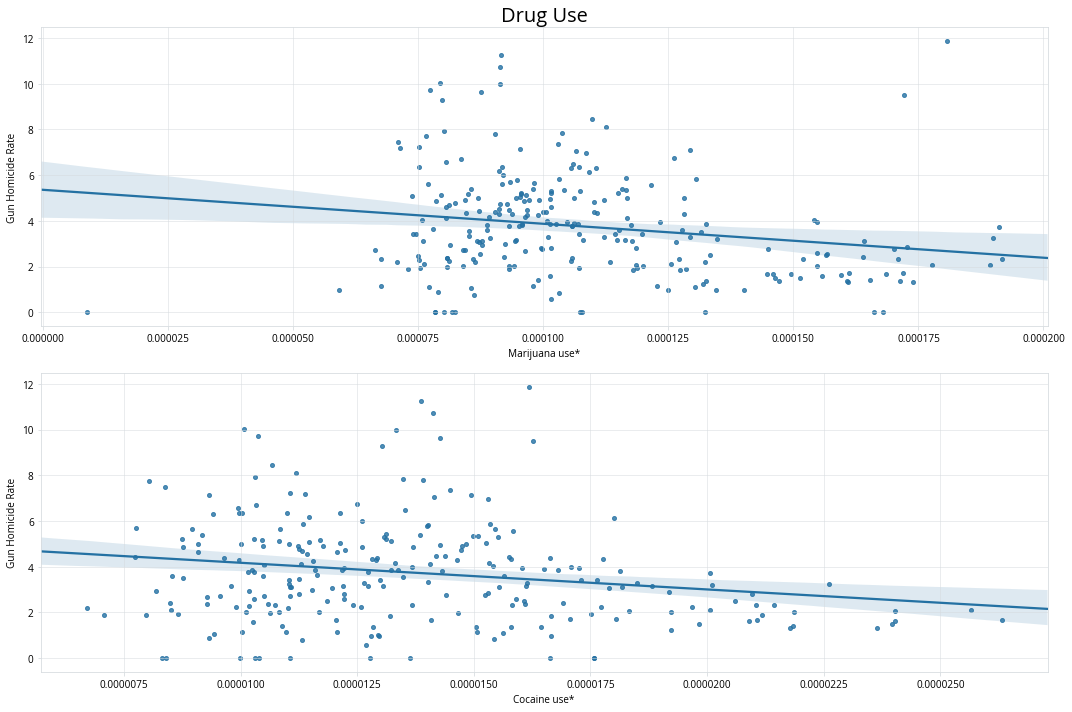

In [1025]:
# Plot gun deaths as they relate to alcohol consumption
to_plot = ['marijuana', 'cocaine']
xlabels = ['Marijuana', 'Cocaine']
n_items = len(to_plot)

temp_df = annual_df[to_plot + ['gun_deaths_norm', 'population']].dropna()

plt.figure(figsize=(15,10))
for i, column in enumerate(to_plot):
    # Normalize by population
    temp_df[column] = temp_df[column] / temp_df['population']
    
    plt.subplot(n_items, 1, i + 1)
    sns.regplot(temp_df[column], temp_df['gun_deaths_norm'])
    plt.ylabel('Gun Homicide Rate')
    plt.xlabel('{} use*'.format(xlabels[i]))
    apply_styling()

plt.subplot(n_items, 1, 1)
plt.title('Drug Use', size=20)
plt.tight_layout()
plt.show()

\**Drug use is defined by the estimated number per 1,000 people who have used the drug in the past year.*  

## Election Results

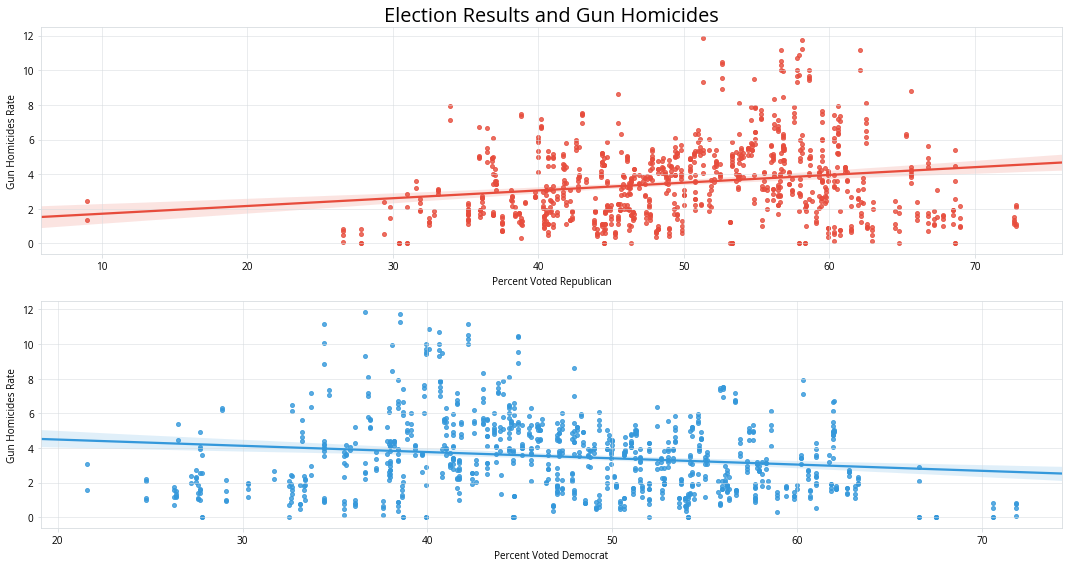

In [1026]:
# Plot gun violence as it relates to election results
# Republican
plt.subplot(2, 1, 1)
sns.regplot(annual_df['republican'], annual_df['gun_deaths_norm'], color='#e74c3c')
plt.xlabel("Percent Voted Republican")
plt.ylabel("Gun Homicides Rate")
apply_styling()

# Democrat
plt.subplot(2, 1, 2)
sns.regplot(annual_df['democrat'], annual_df['gun_deaths_norm'], color='#3498db')
plt.xlabel("Percent Voted Democrat")
plt.ylabel("Gun Homicides Rate")
apply_styling()

plt.subplot(2, 1, 1)
plt.title('Election Results and Gun Homicides', size=20)
plt.tight_layout()
plt.show()

Gun violence rates seems to be **positively correlated with Republican presidential candidate votes**. This would make sense, as the Republican platform strongly supports gun rights.
***

# Examining Trends Within Each State
We now look at each state individually, and analyze the gun violence trends within each state. Our goal here is to see if there is **correlation within each state over time**.

## Plotting feature trends alongside gun violence trends.
First, let's just take a look at some features and see how their trends change with gun violence trends. I have selected the interesting features to display below. These features have been standardized to be plotted on the same y axis. Furthermore, for some features, the trend was removed by taking an nth order difference in order to better represent any correlation between the feature and gun violence.

#### Only a random subset of the states are used in these visualizations.

## Gun Control Trend

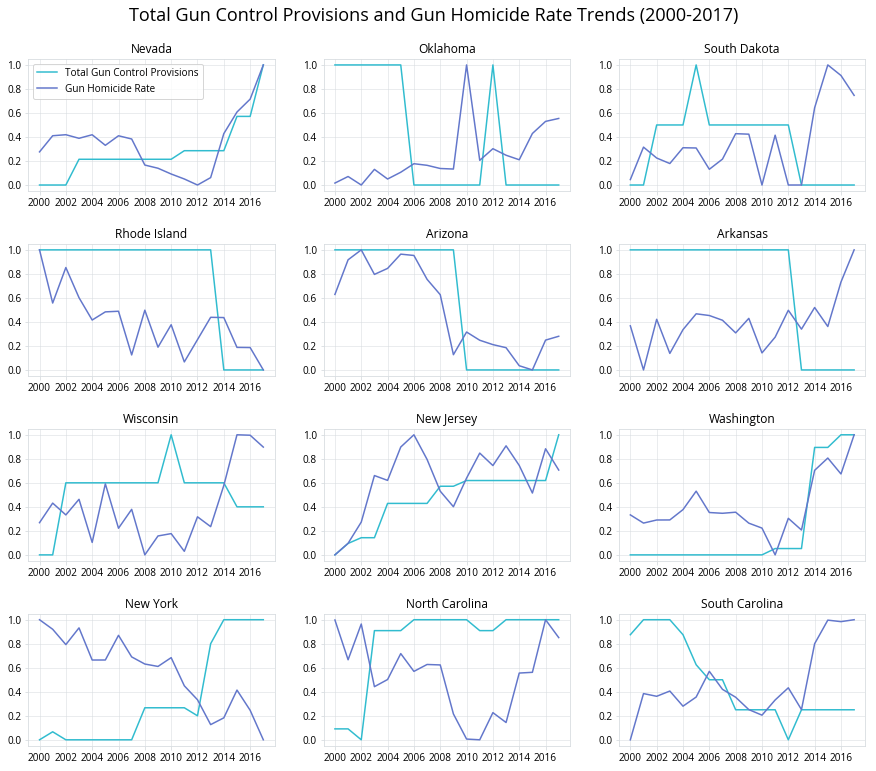

In [1027]:
# Visualize total gun control provisions
plot_feature_trends('lawtotal', 'Total Gun Control Provisions', 
                    colors=['#31bccf', '#6377cb'])

## Increases in gun control provisions seems to follow increases gun violence rates.

#### For example, in Oklahoma, when there was a spike in gun violence, gun control provisions also spiked shortly after. In Arizona, when gun violence went down, so did the strictness of gun control policy.

## In some states, the effects of gun control provisions has a noticable inverse correlation with gun violence???
#### In New York, when gun provisions went up, gun violence went down. Inversely, in Arkansas, when gun provisions went down, gun violence went up. This inverse correlation can be seen in South Carolina as well.

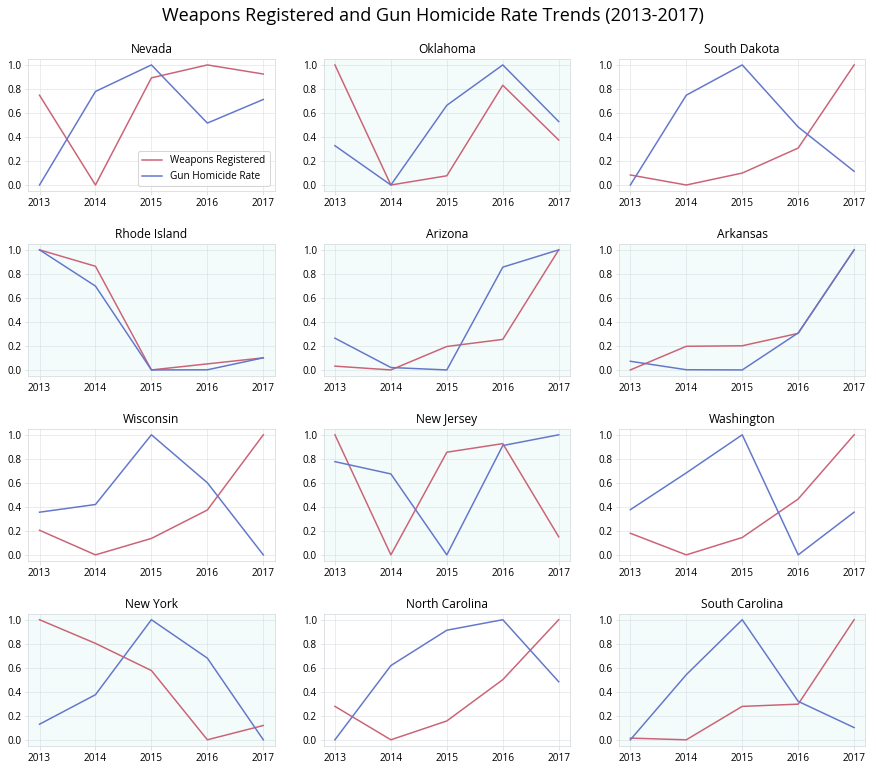

In [1028]:
# Visualize total weapons registrations
highlight_states = ['Oklahoma', 'Rhode Island', 'Arizona', 'Arkansas', 
                    'New Jersey', 'New York', 'South Carolina']

plot_feature_trends('total_weapons', 'Weapons Registered', 
                    colors=['#cb6377', '#6377cb'], order=(2, 2), 
                    highlight=highlight_states)


## There is correlation between weapons registered and the gun violence rates.
#### In most of the states above such as Nevada, Oklahoma, Rhode Island, Arizona, Arkansas, New Jersey, New York, and South Carolina, increases in gun violence closely follow increases in weapons registered. 

In [1168]:
# # Visualize alcohol abuse
# plot_feature_trends('alcohol_abuse', 'Alcohol Abuse', 
#                     colors=['#edc763', '#6377cb'], order=(1,1))

# # Visualize cocaine use
# plot_feature_trends('cocaine', 'Cocaine Use', 
#                     colors=['#787d92', '#6377cb'], order=(1,1))

# # Visualize income trends
# plot_feature_trends('income', 'Income', 
#                     colors=['#77cb63', '#6377cb'], order=(2,2))

# # Visualize income trends
# plot_feature_trends('income', 'Income', 
#                     colors=['#77cb63', '#6377cb'], order=(2,2))

# # Visualize income trends
# plot_feature_trends('other_crime', 'Other Crime', 
#                     colors=['#77cb63', '#6377cb'], order=(2,2))

# # Visualize income trends
# plot_feature_trends('tobacco', 'Tobacco', 
#                     colors=['#77cb63', '#6377cb'], order=(2,2))

# # Visualize income trends
# plot_feature_trends('mental', 'Mental', 
#                     colors=['#77cb63', '#6377cb'], order=(2,2))

### We can see that most of the states plotted above have seen increases in gun violence over the last few years.

## Which states have actually seen decreases in gun violence?

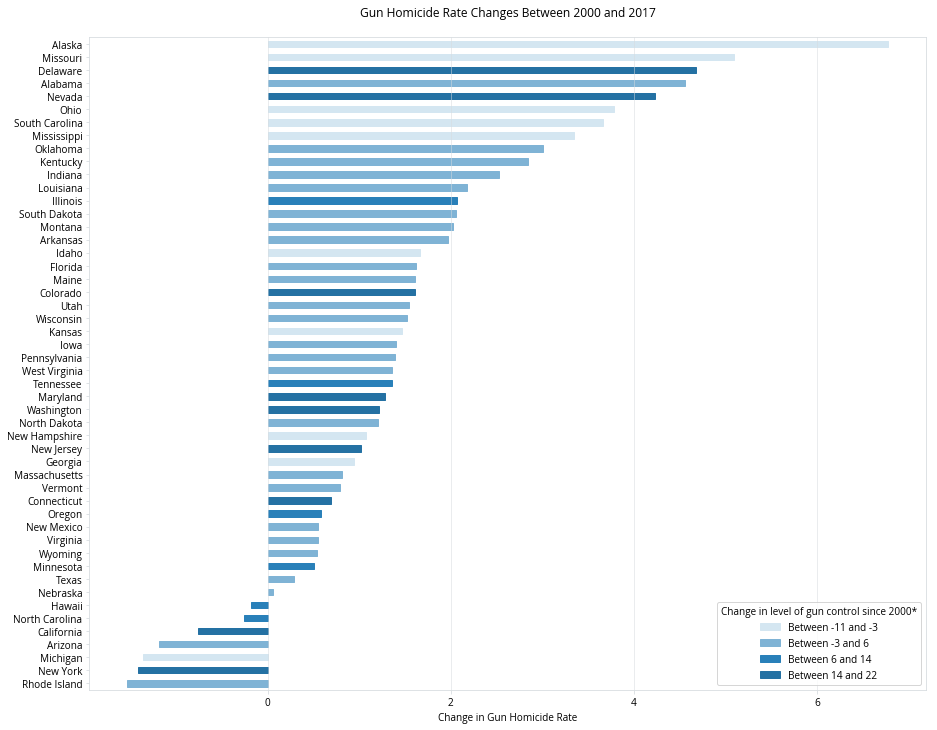

In [1032]:
state_differences = pd.DataFrame()
state_differences['state'] = states

# Get gun death rate differences from 2000 to 2017
gun_deaths_2000 = annual_df[annual_df['year'] == 2000]['gun_deaths_norm']
gun_deaths_2017 = annual_df[annual_df['year'] == 2017]['gun_deaths_norm']
gun_death_diff =  gun_deaths_2017.values - gun_deaths_2000.values

# Get lawtotal differences from 2000 to 2017
lawtotal_2000 = annual_df[annual_df['year'] == 2000]['lawtotal']
lawtotal_2017 = annual_df[annual_df['year'] == 2017]['lawtotal']
lawtotal_diff = lawtotal_2017.values - lawtotal_2000.values

# Include the differences between 2017 and 2000
state_differences['gun_death_diff'] = gun_death_diff
state_differences['lawtotal_diff'] = lawtotal_diff

# Sort by gun_death_diff and plot
state_differences = state_differences.sort_values('gun_death_diff').set_index('state')


# Plot the bars
plt.figure(figsize=(15, 12))
barlist = state_differences['gun_death_diff'].plot(kind='barh').containers[0]

# Get lawtotal_diff bins, and encode them as integers
lawtotal_diff = pd.cut(state_differences['lawtotal_diff'], 4)
le = LabelEncoder()
lawtotal_diff = le.fit_transform(lawtotal_diff)

# Color them based off bins using integers as indices to the colormap
color_map=['#D4E6F1', '#7FB3D5', '#2980B9', '#2471A3'] # colors to encode with
[b.set_color(color_map[i]) for b, i in zip(barlist, lawtotal_diff)]

# Create a legend
labels = le.inverse_transform(range(len(le.classes_)))
legend_labels = ['Between {:.0f} and {:.0f}'\
                 .format(label.left, label.right) for label in labels]

patches = [mpl.patches.Patch(color=c, label=legend_label) 
           for c, legend_label in zip(color_map, legend_labels)]

plt.legend(handles=patches, title='Change in level of gun control since 2000*', loc='lower right')

# Extra styling for readability
plt.title('Gun Homicide Rate Changes Between 2000 and 2017\n')
plt.xlabel('Change in Gun Homicide Rate')
plt.ylabel('')
apply_styling(grid='x')
plt.show()

## Only 7 states have seen a decrease in gun violence from 2000 to 2017.
Rhode Island, New York, Michigan, Arizona, California, North Carolina, and Hawaii are the only states that have seen decreases in gun violence rates since 2000.

### Furthermore, states with larger increases in gun control provisions generally had lower increases in gun violence.

## How have gun control provisions changed over time for the 5 states with the biggest decreases in gun violence?

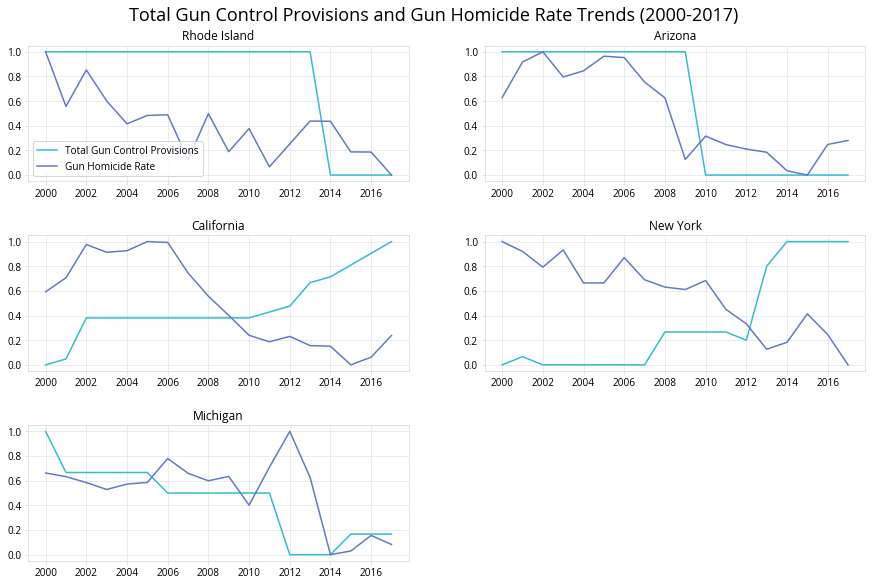

In [1033]:
# Visualize total gun control provisions
plot_feature_trends('lawtotal', 'Total Gun Control Provisions', 
                    colors=['#31bccf', '#6377cb'], 
                    states=['Rhode Island', 'Arizona', 'California', 'New York', 'Michigan'],
                   cols=2, rows=3)

### We can see that in New York and California, as gun control provisions increased, gun homicide rates went down.
### In Arizona and Rhode Island, as gun violence decreases, gun control laws became more lenient (perhaps as a reaction to the already decreasing gun violence).

## How have gun control provisions changed over time for the 5 states with the biggest increases in gun violence?

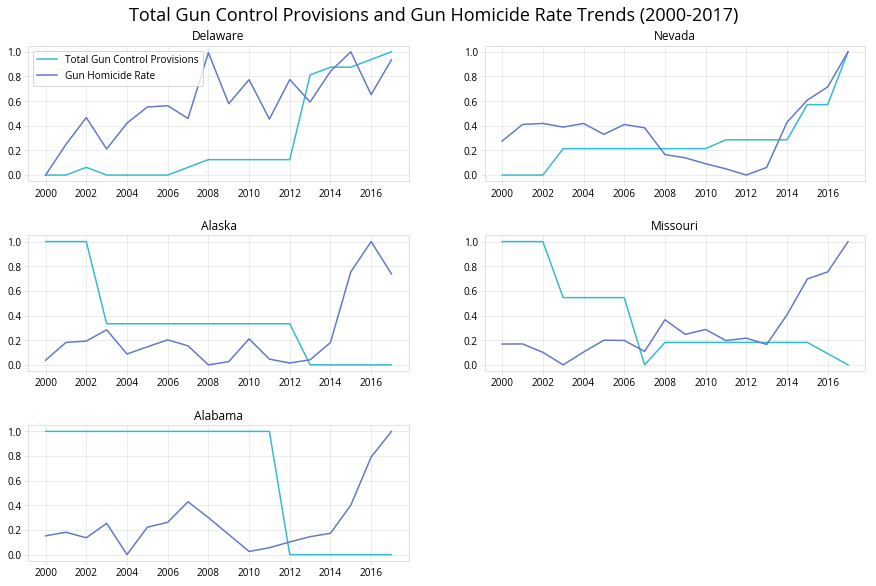

In [1034]:
plot_feature_trends('lawtotal', 'Total Gun Control Provisions', 
                    colors=['#31bccf', '#6377cb'], 
                    states=['Delaware', 'Nevada', 'Alaska', 'Missouri',  'Alabama'],
                   cols=2, rows=3)

### We can see that in Alaska, Missouri, and Alabama that gun violence increases directly followed decreases in gun control provisions.
### In Nevada and Delaware, gun control provisions increase follow gun violence increases; likely as a reactive measure to reduce gun violence.

In [1170]:
# # Visualize total weapons registrations
# highlight_states = ['Oklahoma', 'Rhode Island', 'Arizona', 'Arkansas', 
#                     'New Jersey', 'New York', 'South Carolina']

# to_use=['Alaska', 'Missouri', 'Delaware', 'Alabama', 'Nevada', 
#         'Rhode Island', 'New York', 'Michigan', 'Arizona', 'California']

# plot_feature_trends('total_weapons', 'Weapons Registered', 
#                     colors=['#cb6377', '#6377cb'], order=(2,2), 
#                     states=to_use)


# Analyzing the Effects of Provisions
Let's look at gun control provisions and how they relate to gun violence rates. First, we examine a simple statistic: the mean gun violence rates for states with a certain provision.

In [1036]:
# Function to compare the effects of provisions on gun violence
def compare_provisions(annual_df, provisions_df, threshold=15, year=2017):
    """Return a DataFrame with differences in gun homicides w.r.t. provisions 
    
    threshold   (int): the minimum number of states that have the provision for it 
    to be included in the results. This prevents misleading results (e.g. from 
    laws that only Hawaii has) and helps to control for sample size difference.

    year        (int): the year which we should conduct our comparisons in. We 
    focus on one year because we used an independent t-test and observations 
    from the same state across different years are not independent, whereas 
    assuming independence of observations from different states is not as assuming.   
    """

    # Create a dataframe with 2017 entires 
    provisions = provisions_df.columns[2:-1]
    filtered_df = pd.merge(annual_df, provisions_df)
    filtered_df = filtered_df[filtered_df['year'] == year]

    # Remove where provisions sum less than threshold
    
    provisions = provisions[filtered_df[provisions].sum() > threshold]

    # Lists to remember gun homicides p_values for states w/ and w/o each law 
    a_list, b_list, p_list, a_size_list = [], [], [], []

    # Find differences between states w/wo each law
    for p in provisions:
        ab = filtered_df.groupby(p)['gun_deaths_norm'].mean()
        # Append the a and b means to a_list and b_list
        a_list.append(ab[0])
        b_list.append(ab[1])

        # Get a p value using the Welch's t-test; **assumptions of t-test
        without_law = filtered_df[filtered_df[p] == 0]['gun_deaths_norm']
        with_law = filtered_df[filtered_df[p] == 1]['gun_deaths_norm']
        p_list.append(scipy.stats.ttest_ind(without_law, with_law).pvalue)

        a_size_list.append(filtered_df[filtered_df[p] == 0].shape[0])

    # Organize our results in a dataframe to make it easy to read
    results_df = pd.DataFrame()
    results_df['provision'] = provisions
    results_df['without'] = a_list
    results_df['with'] = b_list
    results_df['diff'] = results_df['without'] - results_df['with'] 
    results_df['p_value'] = p_list
    results_df['n_without'] = a_size_list
    results_df = results_df.sort_values('diff', ascending=False)

    return results_df

In [1163]:
# Function to compare the effects of pairs of provisions on gun violence
def compare_provision_pairs(annual_df, provisions_df, to_ignore=[], threshold=12, year=2017):
    """Return a DataFrame with differences in gun homicides w.r.t. two provisions 
    
    to_ignore  (list): list of provisions to ignore (e.g. ones that have
    shown statistical significant on their own)
    
    threshold   (int): the minimum number of states that have the provision for it 
    to be included in the results. This prevents misleading results (e.g. from 
    laws that only Hawaii has) and helps to control for sample size difference.

    year        (int): the year which we should conduct our comparisons in. We 
    focus on one year because we used an independent t-test and observations 
    from the same state across different years are not independent, whereas 
    assuming independence of observations from different states is not as assuming.   
    """

    # Create a dataframe with 2017 entires 
    provisions = provisions_df.columns[2:-1]
    filtered_df = pd.merge(annual_df, provisions_df)
    filtered_df = filtered_df[filtered_df['year'] == year]

    # Lists to remember gun homicides p_values for states w/ and w/o each law 
    a_list, b_list, p_list, a_size_list, b_size_list = [], [], [], [], []

    provision_pairs = []
    
    # Find differences between states w/wo each pair of laws
    for i in range(provisions.shape[0]):
        for j in range(i, provisions.shape[0]):
            # p1 p2 the two provisions to use
            p1 = provisions[i]
            p2 = provisions[j]
            
            # Ignore these provisions
            if p1 in to_ignore or p2 in to_ignore:
                continue
                
            ab = filtered_df.groupby([p1, p2])['gun_deaths_norm']
            try:
                if ab.count()[0,0] >= threshold and ab.count()[1, 1] >= threshold:
                    a_list.append(ab.mean()[0, 0])
                    b_list.append(ab.mean()[1, 1])

                    # Get a p value using the Welch's t-test; **assumptions of t-test
                    filter_0_0 = (filtered_df[p1] == 0) & (filtered_df[p2] == 0)
                    filter_1_1 = (filtered_df[p1] == 1) & (filtered_df[p2] == 1)
                    without_law = filtered_df[filter_0_0]['gun_deaths_norm']
                    with_law = filtered_df[filter_1_1]['gun_deaths_norm']
                    p_list.append(scipy.stats.ttest_ind(without_law, with_law).pvalue)
                    
                    # Add the name of the provision pair, and keep track of sample sizes
                    provision_pairs.append(p1 + '_' + p2)
                    a_size_list.append(ab.count()[0, 0])
                    b_size_list.append(ab.count()[1, 1])
                    
            # In the event that ab.count has no [0,0] or [1,1]
            except KeyError:
                pass
            
            
    # Organize our results in a dataframe to make it easy to read
    results_df = pd.DataFrame()
    results_df['provision'] = provision_pairs
    results_df['without'] = a_list
    results_df['with'] = b_list
    results_df['diff'] = results_df['without'] - results_df['with'] 
    results_df['p_value'] = p_list
    results_df['n_without'] = a_size_list
    results_df['n_with'] = b_size_list
    results_df = results_df.sort_values('diff', ascending=False)

    return results_df

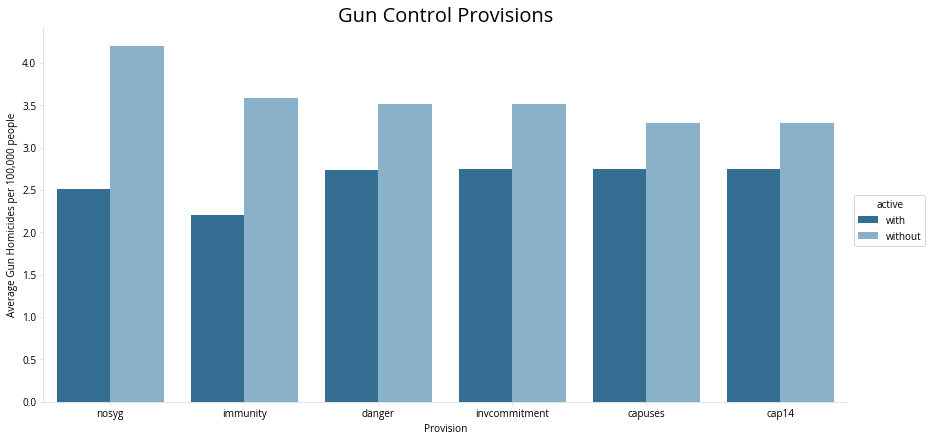

In [1037]:
# Get comparisons between gun homicide rates with and without the provisions
results = compare_provisions(annual_df, provisions_df, 15, 2010)

# Plot the results in a subplot grid
head_size = 6

# Get some of the results to plot and reformat so w/ and w/o columns are in rows instead
results_head = results.head(head_size).set_index('provision')
# results_head = results[results['p_value'] <= 0.05].set_index('provision')
results_head = results_head[['with', 'without']].stack().reset_index()
results_head.columns = ['provision', 'active', 'gun_deaths_norm']

# Plot the with and without side-by-side in a bar graph
facet_grid = sns.factorplot(x='provision', y='gun_deaths_norm',
                hue='active', data=results_head, 
                kind='bar', size=6, aspect=2.0)
plt.title('Gun Control Provisions', size=20)
plt.xlabel('Provision')
plt.ylabel('Average Gun Homicides per 100,000 people')
apply_styling(grid=False)
plt.show()

# Save provisions that may be significantly more useful
useful_provisions = compare_provisions(annual_df, provisions_df, 10, 2017)
useful_provisions = useful_provisions.sort_values('p_value').head(30)
useful_provisions.to_csv('./data/cleaned/useful_provisions.csv')

In [1155]:
results.head(2) # Statistically significant values

,provision,without,with,diff,p_value,n_without
26,age21handgunsale_permith,5.235497,2.698168,2.537328,0.015916,34
423,statechecks_statechecksh,5.336470,2.913307,2.423163,0.020022,34


### We can see that provisions 'nosyg' and 'immunity' had a statistically significant difference in gun violence rates between states that had the provision in place and states that didn't. 

*'**nosyg**' states that use of deadly force is not allowed to be a first resort in public*

*'**immunity**' prohibits state or local lawsuits against gun manufacturers*

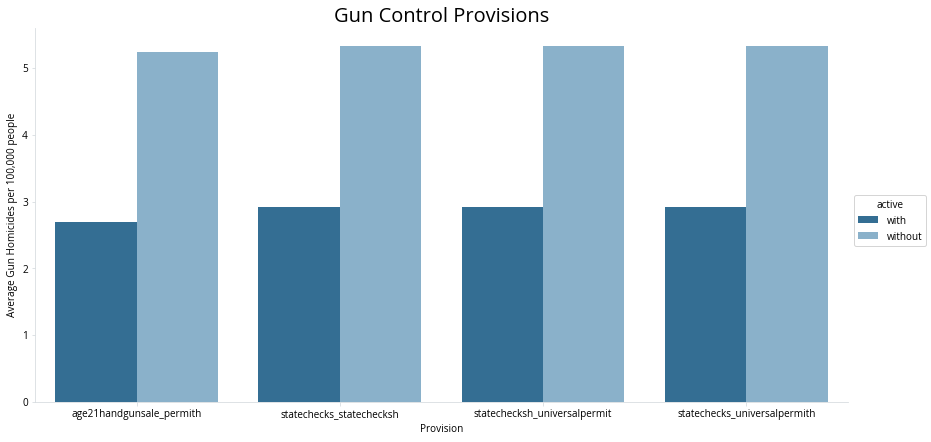

In [1164]:
results = compare_provision_pairs(annual_df, provisions_df, 
                                  ['nosyg', 'immunity'], threshold=10, year=2017)

# Plot the results in a subplot grid
head_size = 4

# Get some of the results to plot and reformat so w/ and w/o columns are in rows instead
results_head = results.head(head_size).set_index('provision')
# results_head = results[results['p_value'] <= 0.05].set_index('provision')
results_head = results_head[['with', 'without']].stack().reset_index()
results_head.columns = ['provision', 'active', 'gun_deaths_norm']

# Plot the with and without side-by-side in a bar graph
facet_grid = sns.factorplot(x='provision', y='gun_deaths_norm',
                hue='active', data=results_head, 
                kind='bar', size=6, aspect=2.0)
plt.title('Gun Control Provisions', size=20)
plt.xlabel('Provision')
plt.ylabel('Average Gun Homicides per 100,000 people')
apply_styling(grid=False)
plt.show()

In [1165]:
results.head(10) # Statistically significant values

,provision,without,with,diff,p_value,n_without,n_with
26,age21handgunsale_permith,5.235497,2.698168,2.537328,0.015916,34,10
423,statechecks_statechecksh,5.336470,2.913307,2.423163,0.020022,34,10
427,statechecksh_universalpermit,5.330041,2.913307,2.416734,0.021859,31,10
425,statechecks_universalpermith,5.330041,2.913307,2.416734,0.021859,31,10
27,age21handgunsale_universalpermith,5.336773,2.982114,2.354659,0.026356,29,11
422,statechecks_statechecks,5.203766,2.913307,2.290459,0.020809,40,10
395,purge_universalpermith,5.330041,3.043809,2.286232,0.030057,31,10
424,statechecks_universalpermit,5.187620,2.913307,2.274313,0.022568,37,10
223,dvrosurrender_mcdvdating,5.652264,3.389762,2.262502,0.045417,27,10
355,mcdvsurrender_universalpermith,5.372366,3.156358,2.216008,0.037010,29,10


## Of the provision pairs, the combination of 'age21handgunsale' and 'permith' had the most significant effect on gun violence.
## Among the statistically significant pairs of provisions, many of them seem to be related to permits and background checks. Let's look at categories of provisions too. 


*'**age21handgunsale**' states that you should be at least 21 years old to buy a handgun.*

*'**permith**' states that you need a license or permit to buy a handgun.*

## Effects of provisions within states
#### California and New York showed decreasing gun violence rates as gun control provisions were added. Alaska, Missouri, and Alabama showed increasing gun violence rates as gun control provisions were removed. Let's take a closer look by seeing which provisions were added / removed by each state.

In [1039]:
# Look for provisions that both California and New York added

ca = provisions_df[provisions_df['state'] == 'California']
ny = provisions_df[provisions_df['state'] == 'New York']

# Get the starting and ending years for each state
ca_2000 = ca[ca['year'] == 2000]
ca_2017 = ca[ca['year'] == 2017]
ny_2000 = ny[ny['year'] == 2000]
ny_2017 = ny[ny['year'] == 2017]

# Take difference, truncating state, year, and lawtotal columns
ca_diffs = ca_2000.values[0][2:-1] - ca_2017.values[0][2:-1]
ny_diffs = ny_2000.values[0][2:-1] - ny_2017.values[0][2:-1]

# ny_diffs + ca_diffs
same = [i + 2 for i, x in enumerate(ca_diffs + ny_diffs) if x == -2] 
print("Provisions added by states with decreasing gun violence:\n{}"\
      .format(ca.columns.values[same]))

Provisions added by states with decreasing gun violence:
['magazinepreowned' 'mcdvsurrender' 'mcdvsurrenderdating'
 'mcdvsurrendernoconditions']


In [1076]:
cany = ca_2017.values[0][2:-1] + ny_2017.values[0][2:-1]

cany = [True if c == 2 else False for c in cany]

allbad = provisions_df[provisions_df['year'] == 2017].sum().values[2:-1]

allbad = pd.DataFrame(allbad)
allbad.columns=['difz']
allbad['provision'] = ca.columns.values[2:-1]
allbad[cany].sort_values('difz')



,difz,provision
69,3,lockstandards
72,3,magazinepreowned
84,3,onefeature
18,4,assaultregister
19,4,assaulttransfer
128,5,violent
129,5,violenth
117,5,tenroundlimit
16,6,assault
17,6,assaultlist


In [1040]:
# Look for provisions that Alaska, Missouri, and Alabama removed

ak = provisions_df[provisions_df['state'] == 'Alaska']
mi = provisions_df[provisions_df['state'] == 'Missouri']
al = provisions_df[provisions_df['state'] == 'Alabama']

# Get the starting and ending years for each state
ak_2000 = ak[ak['year'] == 2000]
ak_2017 = ak[ak['year'] == 2017]
mi_2000 = mi[mi['year'] == 2000]
mi_2017 = mi[mi['year'] == 2017]
al_2000 = al[al['year'] == 2000]
al_2017 = al[al['year'] == 2017]

# Truncate state, year, and lawtotal columns
ak_diffs = ak_2000.values[0][2:-1] - ak_2017.values[0][2:-1]
mi_diffs = mi_2000.values[0][2:-1] - mi_2017.values[0][2:-1]
al_diffs = al_2000.values[0][2:-1] - al_2017.values[0][2:-1]
same = [i + 2 for i, x in enumerate(ak_diffs + mi_diffs + al_diffs) if x >= 2] 
print("Provisions removed by states with increasing gun violence:\n{}"\
      .format(ak.columns.values[same]))

Provisions removed by states with increasing gun violence:
['mayissue' 'nosyg' 'permitconcealed' 'showing']


In [1041]:
def get_rss(X, y):
    # Add constant term to X (a one dimensional np array) and make 2d w/ column variables 
    X = np.vstack([np.ones(X.shape[0]), X]).T
    rss = np.linalg.lstsq(X, y)[1][0]
    return rss

def chow_test(time_series, split):
    """ Simple function to calculate chow test
    time_series   (pandas.Series): Series that contains values to be regressed on.
    split                   (int): Value used to split index.
    """
    before = time_series.loc[:split - 1]
    after = time_series.loc[split:]
    # Degrees of freedom for residual: number of samples - number of parameters - 1
    df_before = before.shape[0]
    df_after = after.shape[0]
    df_pooled = time_series.shape[0]
    
    before_rss = get_rss(before.index, before.values)
    after_rss = get_rss(after.index, after.values)
    pooled_rss = get_rss(time_series.index, time_series.values)
    
    f_top = (pooled_rss - (before_rss + after_rss)) / 2
    f_bottom = (before_rss + after_rss) / (df_before + df_after - 4)
    
    ## F STATISTIC!!!
    f = f_top / f_bottom
    p_value = 1 - scipy.stats.f.cdf(f, 2, df_before + df_after - 4)
    return p_value

# Get where law changes
def get_law_changes(filtered_provisions, state):
    changes = filtered_provisions[state] - filtered_provisions[state].shift()
    changes = changes.dropna()
    changes = changes[changes != 0]
    return changes.apply(lambda x: 'Added' if x > 0 else 'Removed')

# Plot provision
def visualize_provision(provision, lower_thresh=1, upper_thresh=16):
    # Get the provision we want; note we access provisions_df from outside this function
    one_provision_df = provisions_df[['state', 'year', provision]]

    # Get states within threshold of number of years the provision was held for
    by_states_df = one_provision_df.groupby('state')[provision].sum()
    apply_threshold = (by_states_df > lower_thresh) & (by_states_df < upper_thresh)
    by_states_df = by_states_df[apply_threshold]

    # Filter from the one_provision_df
    filtered_provisions = one_provision_df.set_index('state').loc[by_states_df.index]
    filtered_provisions = filtered_provisions.pivot_table(index='year', 
                                                          columns='state', 
                                                          values=provision)
    
    # Get annual gun homicides indexed by year w/ states in columns
    annual_by_date_df = annual_df.pivot_table(index='year', 
                                              columns='state', 
                                              values='gun_deaths_norm')
    # Get number of states to plot, and calculate number of rows to make
    n = filtered_provisions.columns.shape[0]
    rows = n // 2 + 1
    
    # Make the figure bigger based off how many rows we have
    plt.figure(figsize=(15, rows * 4))
    
    # Plot each state's gun homicide rate and the national average
    for i, state in enumerate(filtered_provisions.columns):
        plt.subplot(rows, 2, i + 1)
        # Get bounds for law changes
        law_changes = get_law_changes(filtered_provisions, state)

        # Get chow tests for each law change
        chow_tests = []
        for year in law_changes.index:
            # Get chow test statistic
            chow = chow_test((annual_by_date_df[state] - annual_by_date_df[state].shift()).dropna(), year)
            chow_tests.append(chow)
        
        chow_tests = pd.Series(chow_tests)
        chow_tests.index = law_changes.index

        # Get entries excluding the state of interest
        exclude_state = annual_df[annual_df['state'] != state]

        # Calculate national total and average from those entries
        national_total = exclude_state.groupby('year')['gun_deaths'].sum(axis=1)
        national_avg = national_total / exclude_state.groupby('year')['population'].sum()
        national_avg = national_avg * 100000
        
        
        # Take difference of trends from the state and the national average and plot it
        difference = annual_by_date_df[state]
#         difference = annual_by_date_df[state] - national_avg
        difference = annual_by_date_df[state] - annual_by_date_df[state].shift()
        
        difference.plot(label='State')

        # Plot the national average        
        plt.plot([2000, 2017], [0, 0], ls='--', 
                 label='National Average (State removed)'.format(state))

        y_bounds = plt.ylim()
        # And for each time the law changes, we plot a dotted line to indicate
        for year in law_changes.index:
            plt.plot([year, year], y_bounds, ls='--', color='grey')
            plt.annotate("{} ({:0.2f})".format(law_changes[year], chow_tests[year]),
                         xy=(year + 0.2, y_bounds[1] * 0.95), 
                         textcoords='data', color='k', fontsize=10)
            
        apply_styling()
        plt.title(state)

        if i == 0:
            plt.legend(loc='lower left', framealpha=0.2)
    
    plt.suptitle('Effects of \'{}\' on Gun Violence'.format(provision), fontsize=20)
    
    # Space out the plots a bit more vertically
    plt.subplots_adjust(top=0.84 + (0.015 * rows), hspace=0.4) 
    plt.show()

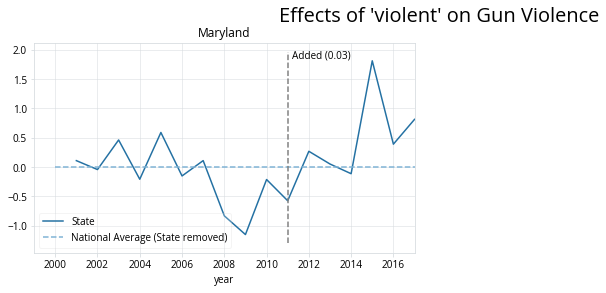

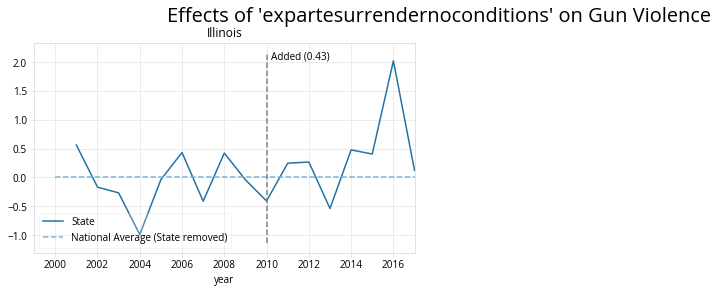

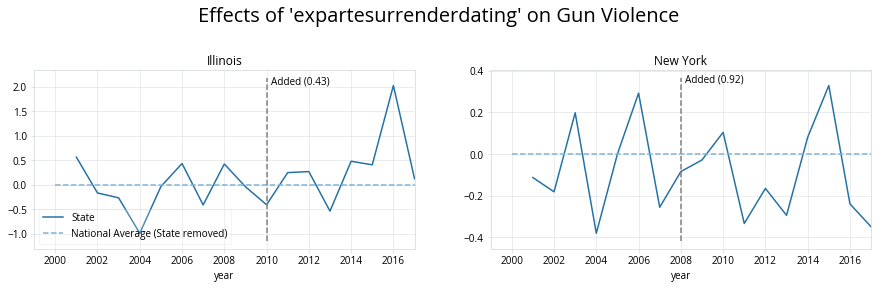

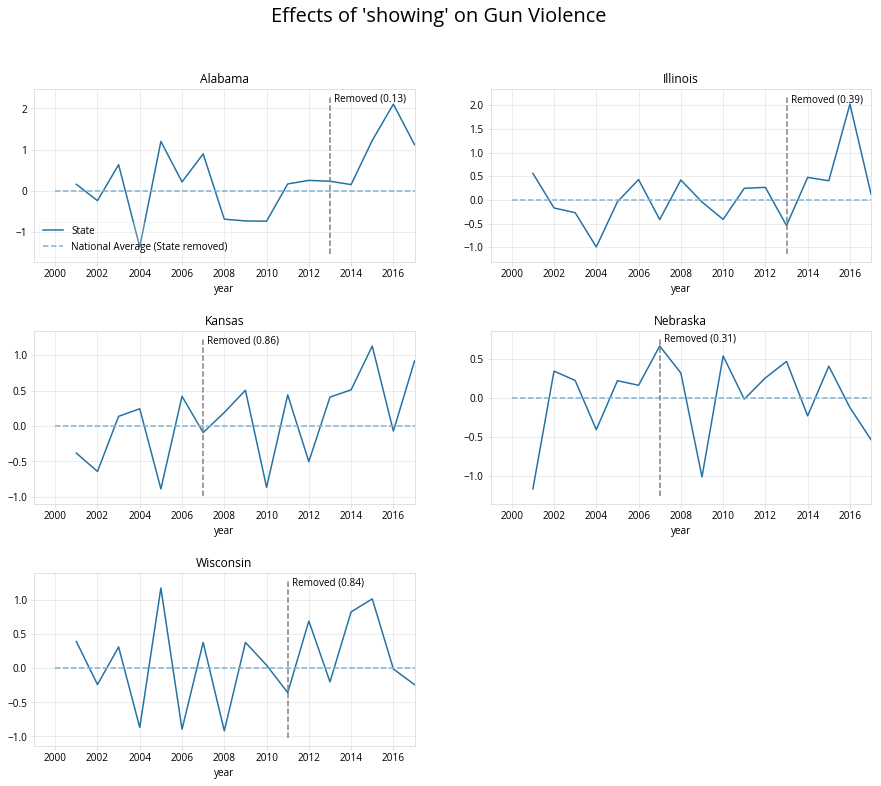

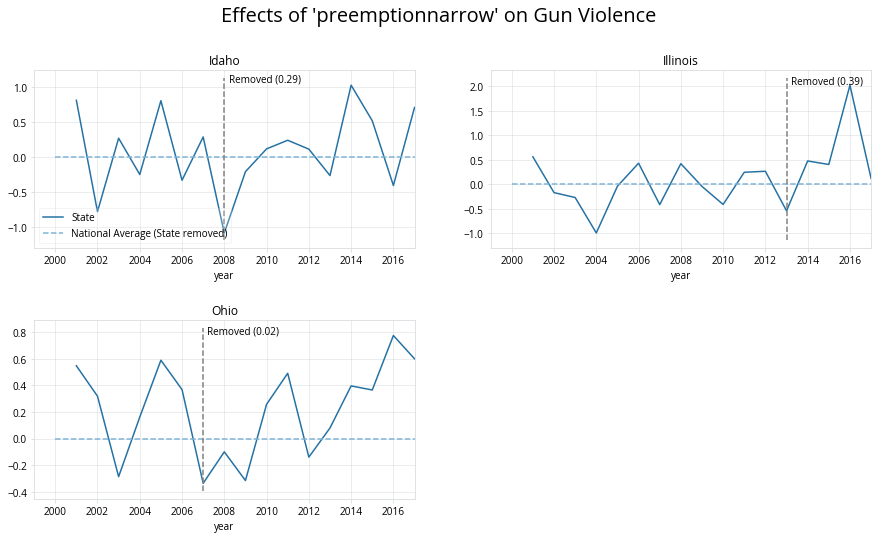

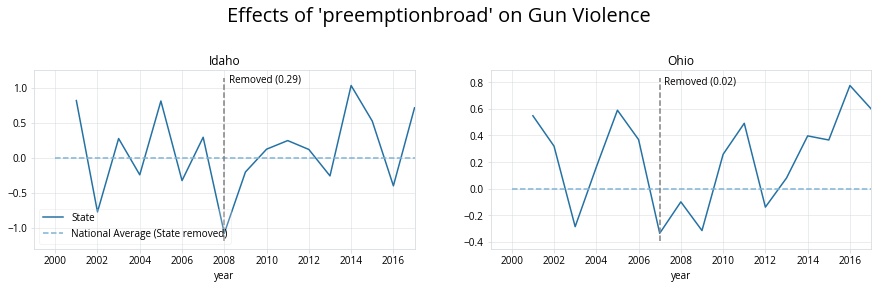

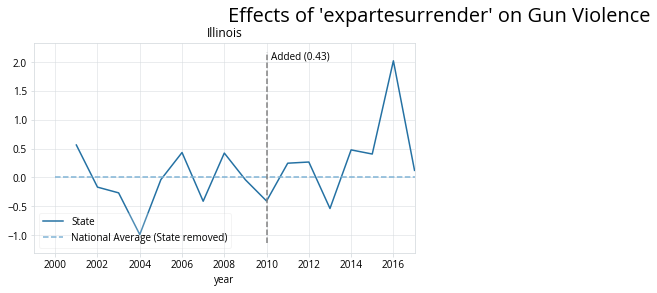

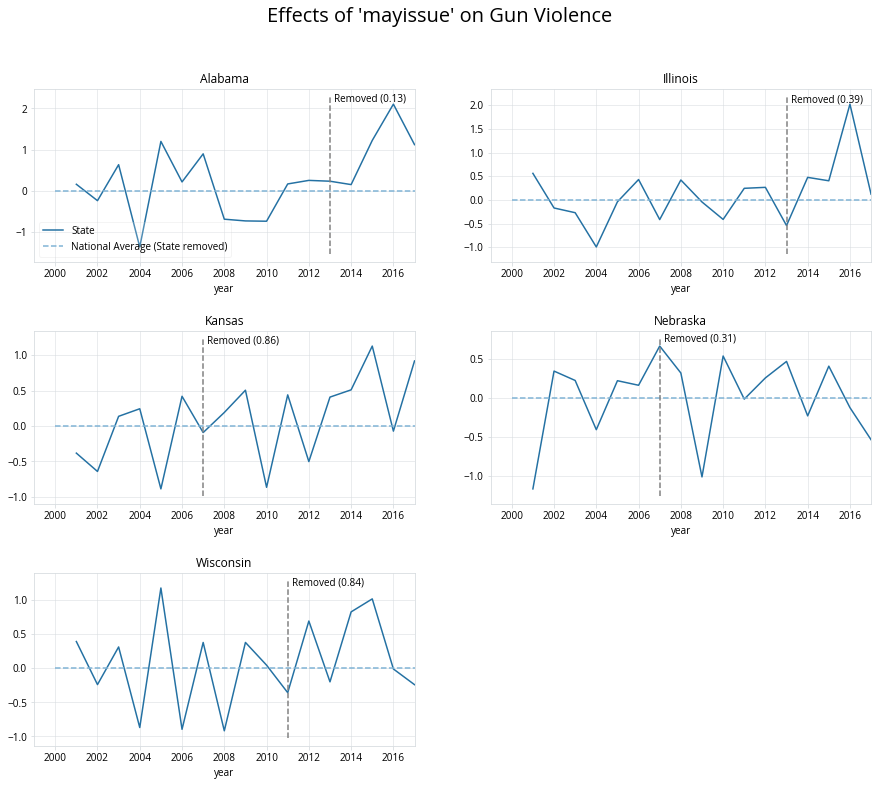

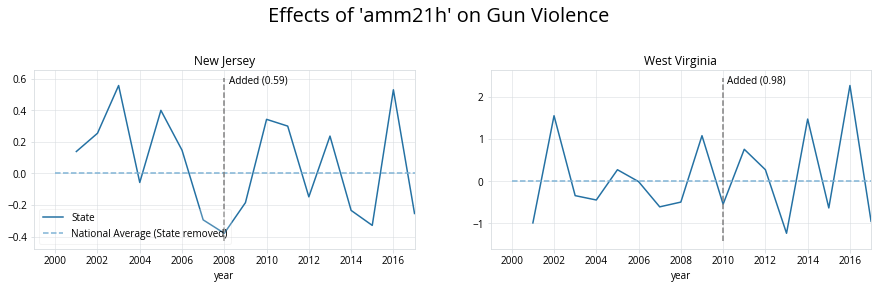

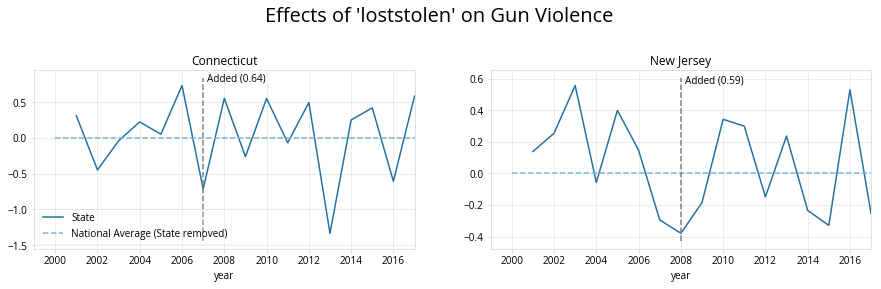

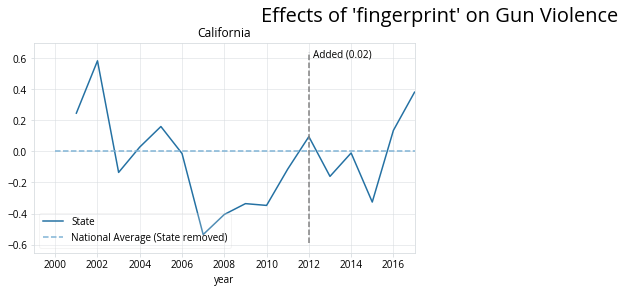

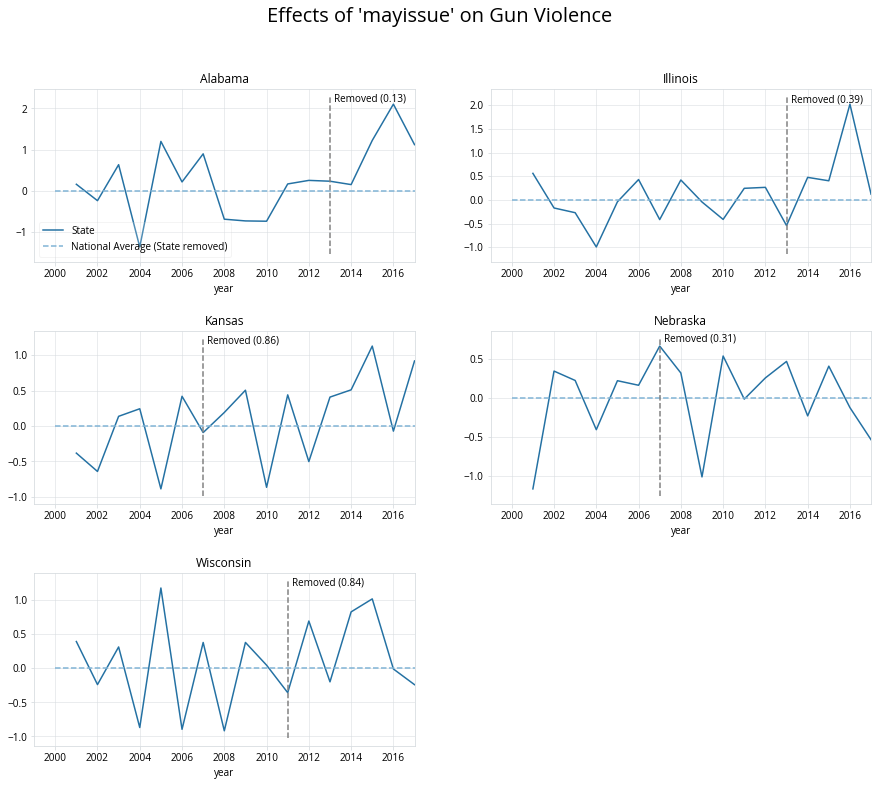

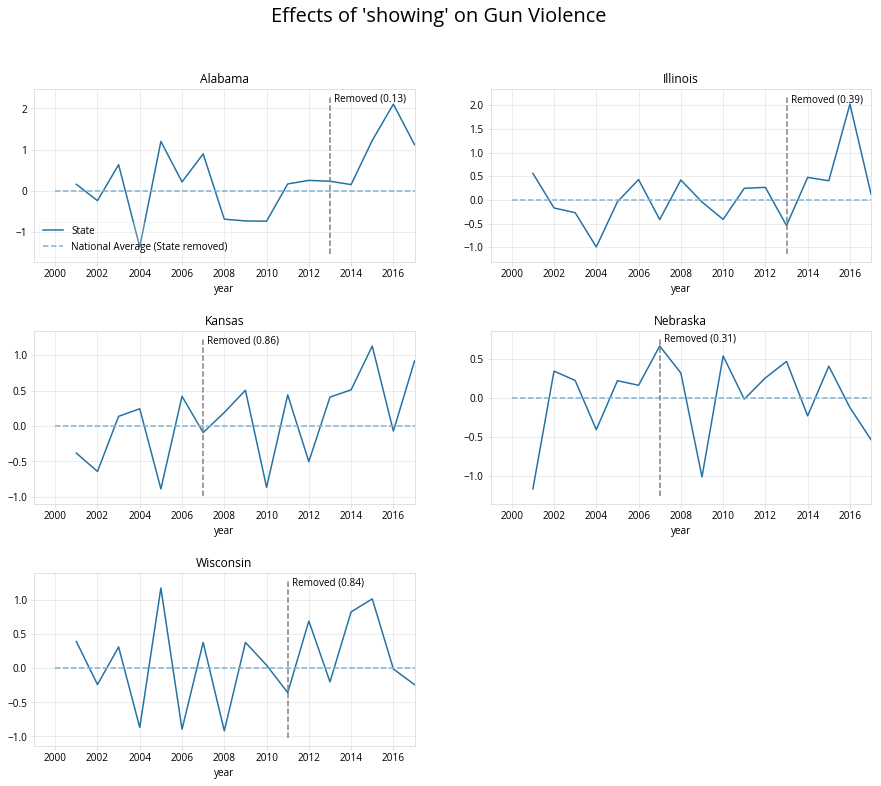

In [1077]:
# Remove dates before 2000 from provisions_df
provisions_df['year'] = provisions_df['year'].astype(int)
provisions_df = provisions_df[provisions_df['year'] >= 2000]

# for provision in provisions_df.columns[2:-1]:
#     visualize_provision(provision, lower_thresh=1, upper_thresh=16)

# Provisions that both California and New York added between 2000 and 2017; 
# contributing to lowered gun violence:
# 'magazinepreowned', 'mcdvsurrender', 'mcdvsurrenderdating', 'mcdvsurrendernoconditions'

# Provisions that both Arizona and Rhode Island maintained 
# while still maintaining decreasing gun violence rates:
# 'age18longgunpossess', 'danger', 'invcommitment', 'invoutpatient'

# Provisions that at least two of Alaska, Missouri, and Alabama repealed
# contributing to increased gun violence:
# 'mayissue', 'nosyg', 'showing', 'permitconcealed'


# for provision in ['magazinepreowned', 'mcdvsurrender', 'mcdvsurrenderdating', 'mcdvsurrendernoconditions']:
#     visualize_provision(provision, lower_thresh=5, upper_thresh=15) # Not bad

for provision in ['lockstandards', 'magazinepreowned', 'onefeature', 'assaultregister', 'assaulttransfer', 'violent', 'violenth', 'tenroundlimit', 'assault', 'assaultlist', 'magazine', 'expartesurrendernoconditions', 'expartesurrenderdating', 'showing', 'preemptionnarrow', 'mcdvsurrenderdating', 'preemptionbroad', 'expartesurrender', 'mentalhealth', 'mayissue', 'amm21h', 'loststolen', 'fingerprint'] :
    visualize_provision(provision, lower_thresh=5, upper_thresh=15) # Not bad
    
# After looking through the provisions, I chose some that seemed to be particularly interesting
visualize_provision('mayissue', lower_thresh=5, upper_thresh=15) # Good!**
visualize_provision('showing', lower_thresh=5, upper_thresh=15) # Good!**



### Here, we try to find states that had similar provisions in 2000 but big differences by 2017. By doing so, we hope to examine whether these differences had an effect in gun violence trends.

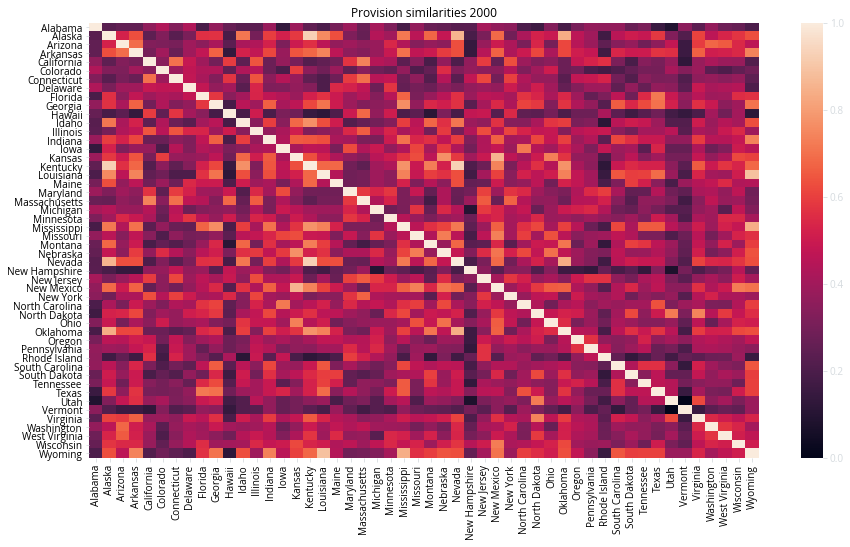

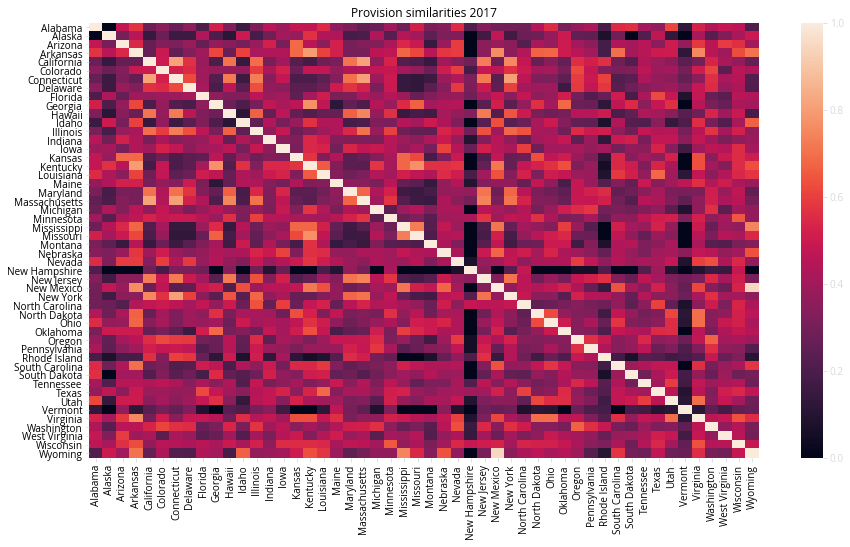

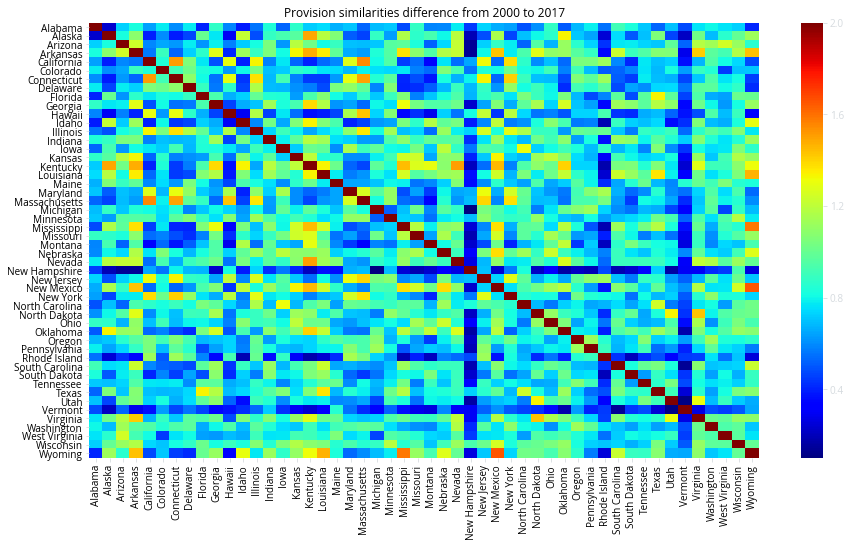

In [1044]:
# Get the provisions from year 2000 (remove state, year, and lawtotal columns)
provisions_2000 = provisions_df[provisions_df['year'] == 2000].values[:, 2:-1]
provisions_2017 = provisions_df[provisions_df['year'] == 2017].values[:, 2:-1]

# Get similarities (using cosine similarity)
similarities_2000 = cosine_similarity(provisions_2000)
similarities_2017 = cosine_similarity(provisions_2017)

# We look for white squares, meaning similar
sns.heatmap(similarities_2000, xticklabels=states, yticklabels=states)
apply_styling(grid=False)
plt.title("Provision similarities 2000")
plt.show()

sns.heatmap(similarities_2017, xticklabels=states, yticklabels=states)
apply_styling(grid=False)
plt.title("Provision similarities 2017")
plt.show()

# Looking for dark red squares
sns.heatmap(np.abs(similarities_2000 + similarities_2017), xticklabels=states, yticklabels=states, cmap='jet')
apply_styling(grid=False)
plt.title("Provision similarities difference from 2000 to 2017")
plt.show()

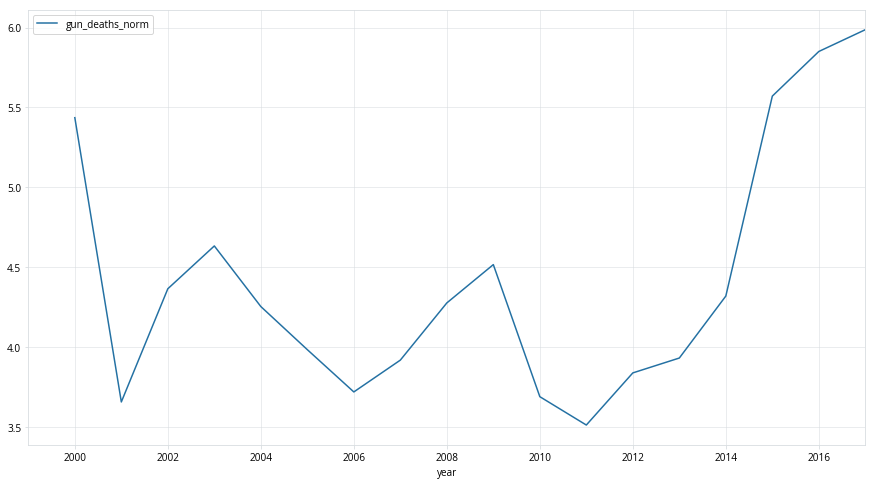

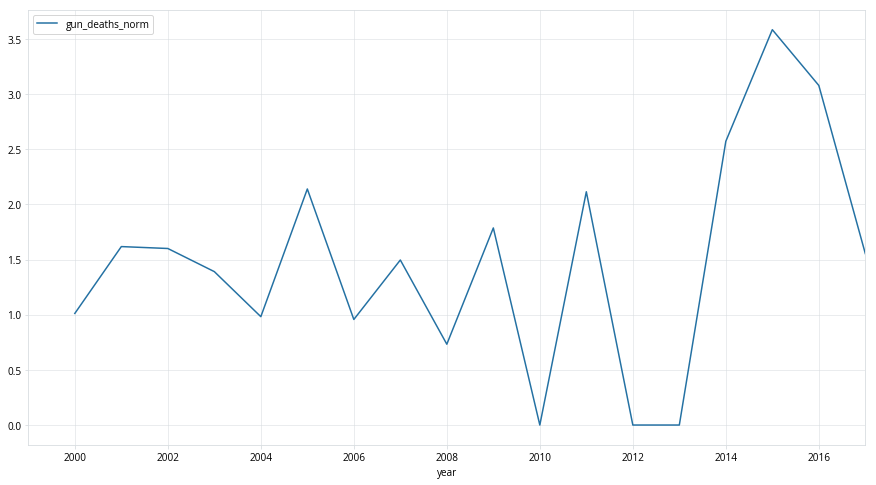

In [1047]:
kansas_deaths = annual_df[annual_df['state'] == 'New Mexico'][['year', 'gun_deaths_norm']]
nebraska_deaths = annual_df[annual_df['state'] == 'Wyoming'][['year', 'gun_deaths_norm']]

kansas_deaths = kansas_deaths.set_index('year')
nebraska_deaths = nebraska_deaths.set_index('year')
kansas_deaths.plot() 
apply_styling()
nebraska_deaths.plot()
apply_styling()
plt.show()

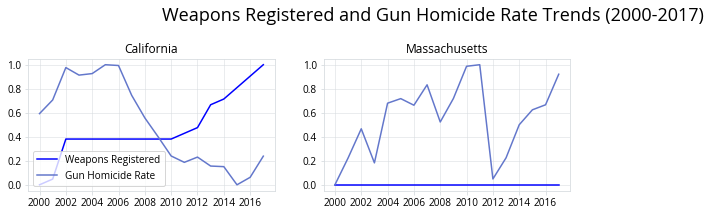

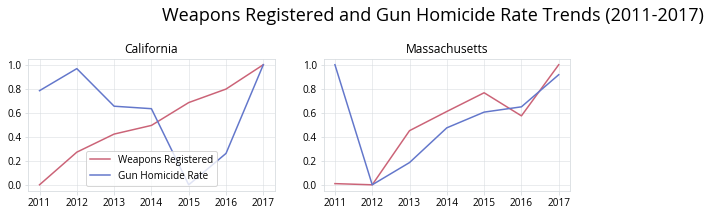

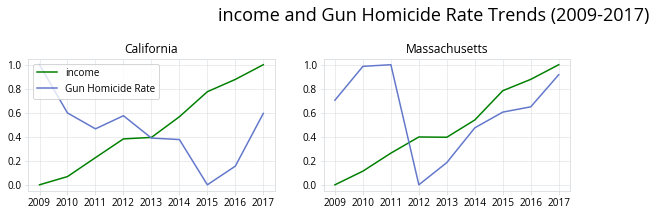

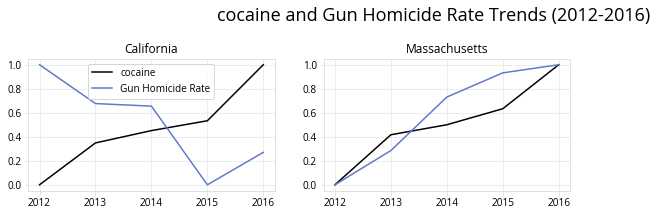

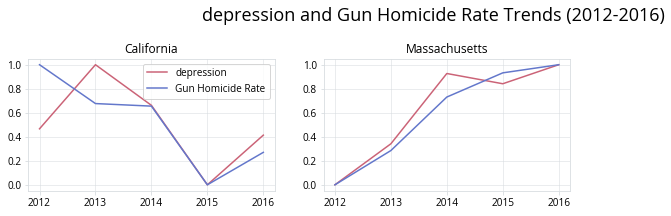

In [1054]:
# Visualize total weapons registrations
states=['California', 'Massachusetts']
plot_feature_trends('lawtotal', 'Weapons Registered', 
                    colors=['b', '#6377cb'], order=(0,0), 
                    states=states)

# Visualize total weapons registrations
plot_feature_trends('total_weapons_norm', 'Weapons Registered', 
                    colors=['#cb6377', '#6377cb'], order=(0,0), 
                    states=states)

# Visualize total weapons registrations
plot_feature_trends('income', 
                    colors=['g', '#6377cb'], order=(0,0), 
                    states=states)


# Visualize total weapons registrations
plot_feature_trends('cocaine', 
                    colors=['k', '#6377cb'], order=(0,0), 
                    states=states)


# Visualize total weapons registrations
plot_feature_trends('depression', 
                    colors=['#cb6377', '#6377cb'], order=(0,0), 
                    states=states)

In [369]:
# California and Massachusetts

,state,year,gun_deaths,population,violent_crime,property_crime,murder_crime,rape_crime,robbery_crime,assault_crime,...,short_barreled_shotgun,total_weapons,marijuana,cocaine,tobacco,alcohol_abuse,mental,depression,gun_deaths_norm,other_crime_norm
18,Alabama,2017,544.0,4874747.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2294.0,161641.0,NaN,NaN,NaN,NaN,NaN,NaN,11.159554,NaN
37,Alaska,2017,69.0,739795.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1302.0,15824.0,NaN,NaN,NaN,NaN,NaN,NaN,9.326908,NaN
56,Arizona,2017,289.0,7016270.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2340.0,179738.0,NaN,NaN,NaN,NaN,NaN,NaN,4.118998,NaN
75,Arkansas,2017,216.0,3004279.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1158.0,79841.0,NaN,NaN,NaN,NaN,NaN,NaN,7.189745,NaN
94,California,2017,1423.0,39536653.0,NaN,NaN,NaN,NaN,NaN,NaN,...,13675.0,344622.0,NaN,NaN,NaN,NaN,NaN,NaN,3.599192,NaN
113,Colorado,2017,199.0,5607154.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1775.0,92435.0,NaN,NaN,NaN,NaN,NaN,NaN,3.549038,NaN
132,Connecticut,2017,89.0,3588184.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1007.0,82400.0,NaN,NaN,NaN,NaN,NaN,NaN,2.480363,NaN
151,Delaware,2017,56.0,961939.0,NaN,NaN,NaN,NaN,NaN,NaN,...,644.0,4852.0,NaN,NaN,NaN,NaN,NaN,NaN,5.821575,NaN
189,Florida,2017,950.0,20984400.0,NaN,NaN,NaN,NaN,NaN,NaN,...,8710.0,343288.0,NaN,NaN,NaN,NaN,NaN,NaN,4.527173,NaN
208,Georgia,2017,658.0,10429379.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11397.0,190050.0,NaN,NaN,NaN,NaN,NaN,NaN,6.309100,NaN


## From these visualizations, it appears that in many states, the removal of the 'nosyg', which states that use of deadly force is should not be a first resort in public, causes an increase in gun violence

# Maps
Just for fun, let's take a look at a map of the United States and see the amount of gun violence for each state. 

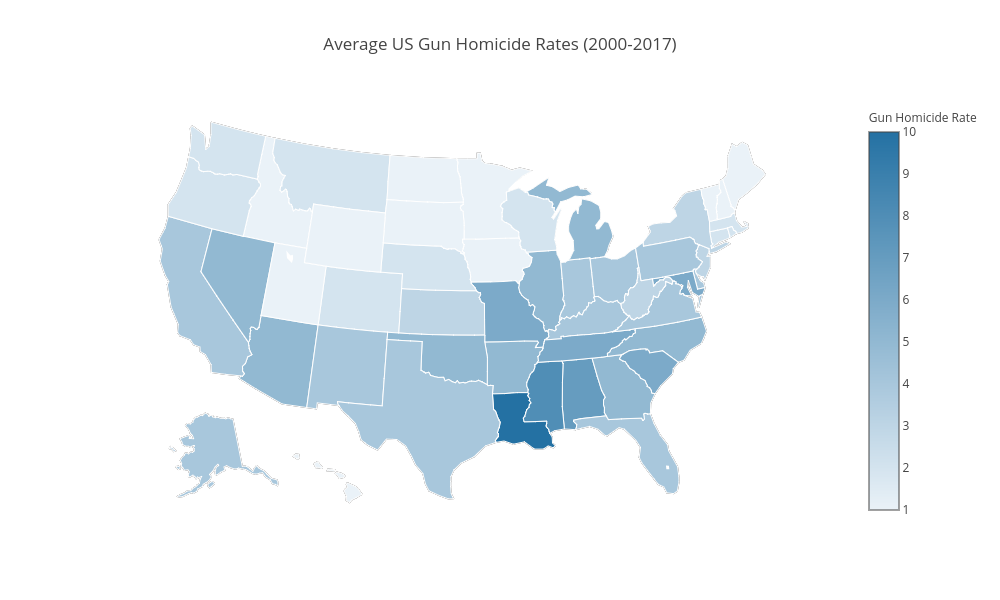

In [786]:
# Map out the normalized crime
# Dictionary to turn state names into abbreviations
states_codes = {
    'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ', 'California': 'CA', 
    'Colorado': 'CO', 'Connecticut': 'CT', 'District of Columbia': 'DC', 'Delaware': 'DE', 
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 'IA', 'Idaho': 'ID', 
    'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 
    'Massachusetts': 'MA', 'Maryland': 'MD', 'Maine': 'ME', 'Michigan': 'MI', 
    'Minnesota': 'MN', 'Missouri': 'MO', 'Northern Mariana Islands': 'MP', 'Mississippi': 'MS', 
    'Montana': 'MT', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Nebraska': 'NE', 
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'Nevada': 'NV', 
    'New York': 'NY', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 
    'Texas': 'TX', 'Utah': 'UT', 'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 
    'Wisconsin': 'WI', 'West Virginia': 'WV', 'Wyoming':  'WY'
}

# Create a color scale for aesthetics
colorscale = [
            [0.0, '#EAF2F8'],
            [1.0, '#2471A3'],
            ]
            
# Mean 2000-2017 murders
annual_mean_df = annual_df.groupby('state').mean().reset_index()
# annual_mean_df = annual_df[annual_df['year'] == 2017]
locations = annual_mean_df['state'].apply(lambda x: states_codes[x])
values = annual_mean_df['gun_deaths_norm'].round()

data = [ dict(
        type='choropleth',
        colorscale = colorscale,
        autocolorscale = False,
        locations = locations,
        z = values,
        locationmode = 'USA-states',
        text = annual_mean_df['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Gun Homicide Rate")
        )]

layout = dict(
#         title = 'US Gun Homicide Rates (2017)',
        title = 'Average US Gun Homicide Rates (2000-2017)',
        font=dict(family='Open Sans', size=12),
        width = 1000,
        height = 600,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
            countrycolor = '#d9d9d9',
            countrywidth = 1,
        )
        )
    
fig = dict(data=data, layout=layout)

# py.iplot(fig, validate=False, filename='map3')
py.image.ishow(fig) # Since py.iplot doesn't work with on GitHub?

In [20]:
# Slider version that probably doesn't work on GitHub:

# Create a DataFrame so that year is in columns and state in rows
annual_pivot_df = annual_df.pivot_table(index='state', columns='year', values='gun_deaths_norm')
annual_pivot_df.columns = annual_pivot_df.columns.astype(str)

# Create Grid for annual and lawtotal and upload to plotly
locations = [states_codes[x] for x in annual_pivot_df.index]
years = annual_pivot_df.columns
annual_columns = []

for year in years:
    annual_columns.append(Column(annual_pivot_df[year], year))
    
annual_columns.append(Column(locations, 'locations'))

annual_grid = Grid(annual_columns)
annual_url = py.grid_ops.upload(annual_grid, 'annual grid' + str(time.time()))

In [787]:
# Figure template
figure = {
    'data': [],
    'layout': {},
    'frames': [],
    'config': {'scrollzoom': True}
}

# Set up the layout
layout = {}
layout['title'] = 'US Gun Homicide Rates (2000-2017)'
layout['width'] = 1000
layout['height'] = 600
layout['geo'] = {
    'scope': 'usa',
    'projection': { 'type': 'albers usa' },
    'showlakes': True,
    'lakecolor': '#ffffff',
    'countrycolor': '#d9d9d9',
    'countrywidth': 1    
}

figure['layout'] = layout

# Add a play button
figure['layout']['updatemenus'] = [
{
'buttons': [{
        'args': [None, {'frame': {'duration': 500, 'redraw': False},
             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
        'label': 'Play',
        'method': 'animate'
    }],
    'direction': 'left',
    'pad': {'r': 10, 't': 87},
    'showactive': False,
    'type': 'buttons',
    'x': 1.0,
    'xanchor': 'right',
    'y': 0,
    'yanchor': 'top'
}]
            
# Format the slider
sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 16},
        'prefix': 'Year: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 200, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.8,
    'x': 0,
    'y': 0,
    'steps': []
}


# Adding data
year = '2000'

data_dict = {
    'type': 'choropleth',
    'colorscale': colorscale,
    'autocolorscale': False,
    'locationssrc': annual_grid.get_column_reference('locations'),
    'zsrc': annual_grid.get_column_reference(year),
    'locationmode': 'USA-states',
    'marker': {
        'line': {
            'color': '#ffffff',
            'width': 1
        }
    },
    'colorbar': {
        'title': 'Homicides per 100,000 people'
    }
}

# Add the initial data to the figure
figure['data'].append(data_dict)

# Add frames
for year in years:
    frame = {'data': [], 'name': year}
    data_dict = {
        'locationssrc': annual_grid.get_column_reference('locations'),
        'zsrc': annual_grid.get_column_reference(year),
    }
    
    frame['data'].append(data_dict)
    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 10, 'redraw': False},
         'transition': {'duration': 10}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

figure['layout']['sliders'] = [sliders_dict]                 
py.icreate_animations(figure, 'model' + str(time.time()))

In [816]:
# Create a color scale for aesthetics
colorscale = [
            [0.0, '#7FB3D5'],
            [0.2, '#2980B9'],
            [1.0, '#2471A3'],
            ]

# Number of points to sample (getting error from plotly server with too many points)
n_points = 50000
seed = 0

# Get the samples and sort (so large points are plotted on top)
sample_df = lat_long_df[lat_long_df['n_killed'] > 0]
sample_df = sample_df.sample(n_points, random_state=seed).sort_values('n_killed')

data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = sample_df['latitude'],
        lon = sample_df['longitude'],
        text = sample_df['n_killed'],
        mode = 'markers',
        marker = dict(
            size = np.log(sample_df['n_killed']) * 2,
            opacity = 1.0,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width = 0
            ),
            colorscale = colorscale,
            cmin = 0,
            color = sample_df['n_killed'],
            cmax = sample_df['n_killed'].max(),
            colorbar=dict(
                title="Number killed"
            )
        )
        )]

layout = dict(
        title = 'Locations of Gun Homicides (2014-2017)',
        font=dict(family='Open Sans', size=12),
        width = 1000,
        height = 600,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = '#fafafa',
            subunitcolor = '#d9d9d9',
            countrycolor = '#d9d9d9',
            countrywidth = 1,
            subunitwidth = 0.5
        )
    )

fig = dict( data=data, layout=layout )
py.iplot(fig, filename='lat_long_map2')
# py.image.ishow(fig)

/home/jshuai/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



array(['magazinepreowned', 'mcdvsurrender', 'mcdvsurrenderdating',
       'mcdvsurrendernoconditions'], dtype=object)